This is the main population that will be focused on in the paper (derived from Population 5). 


Eccentricity is sampled from Rayleigh Distribution where the Sigma value is normally distributed with a mean of 0.079 and standard deviation of 0.013. 

Period ratios are sampled independently. 


We calculate the pearson r of the periods!!!


In [1]:
#Variables to play with, eventually will be deprecated:
bin_number = 30

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
from scipy.stats import lognorm
import math
import rebound
import random
from numpy.random import seed, random
from scipy.stats import rayleigh
from scipy.stats import norm
import itertools
from spock import FeatureClassifier
from decimal import Decimal
import pandas as pd
import seaborn as sns


%matplotlib inline

fmodel = FeatureClassifier()
earth_mass = 5.97219*10**24
sun_mass = 1.981 * 10**30
mass_ratio = earth_mass/sun_mass


/mnt/ssd/home/bbonifacio/anaconda3/envs/bbonifacio/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


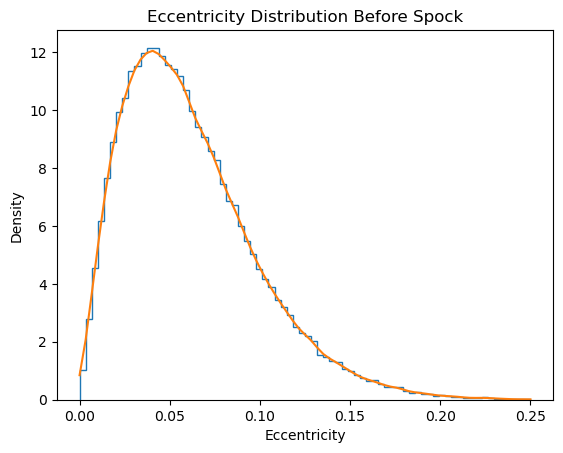

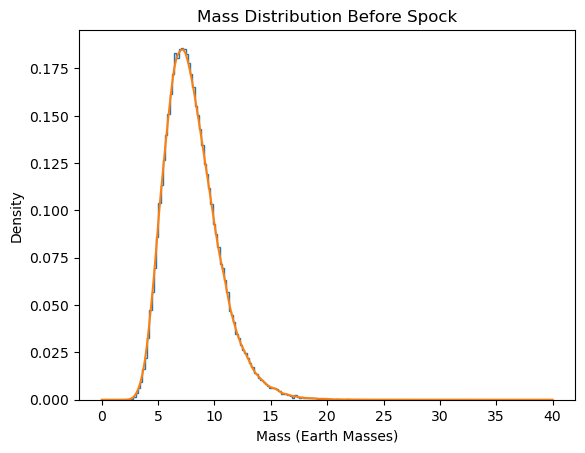

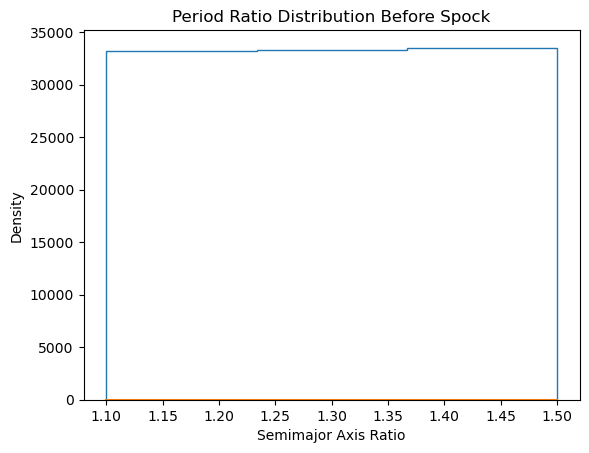

In [3]:
"""
Initialize the original population
"""

num_iter =100000
e_mean = 0.049      #0.02632     #settings["planetary_system"]["mean_e"]
#0.013
e_error=  0.013     #settings["planetary_system"]["e_error"]
m_mean =  7.7         #Wu 2019 Mass and Mass Scalings of Super Earths 
m_error =  0.29    #settings["planetary_system"]["m_error"]
                    #Distribution of period ratios is uniform
p_min = 1.1
p_max = 1.5

e_list = []
p_list = []
m_list = lognorm.rvs(s=m_error, scale=m_mean, size=num_iter) 

for m in m_list:
    if m < 0:
        m_list.remove(m)
        
for i in range(num_iter):
    #Generate p_ratio
    p = np.random.uniform(p_min,p_max)
    p_list.append(p)

    
while len(e_list) < num_iter:
    #Generate e from Rayleigh Distribution
    scale = np.random.normal(e_mean, e_error)
    if scale < 0:
        scale = 0
    e = np.random.rayleigh(scale = scale)
    if not (e < 0 or e > 1):
        e_list.append(e)

density = stats.gaussian_kde(e_list)
n, x, _ = plt.hist(e_list, bins=np.linspace(0, 0.25, 75),
                   histtype=u'step', density=True)  
plt.plot(x, density(x))

plt.title("Eccentricity Distribution Before Spock")
plt.xlabel("Eccentricity")
plt.ylabel("Density")
plt.show()

density = stats.gaussian_kde(m_list)
n, x, _ = plt.hist(m_list,  bins=np.linspace(0, 40, 200),
                   histtype=u'step', density=True)  
plt.plot(x, density(x))
plt.title("Mass Distribution Before Spock")
plt.xlabel("Mass (Earth Masses)")
plt.ylabel("Density")
#plt.xscale("log")
plt.show()


n, x, _ = plt.hist(p_list, bins=np.linspace(1.1,1.5, 4),
                   histtype=u'step', density = False)
plt.plot(x, density(x))
plt.title("Period Ratio Distribution Before Spock")
plt.xlabel("Semimajor Axis Ratio")
plt.ylabel("Density")
plt.show()





In [4]:
#This only needs to be run once
#This initializes the lists that populations can be added into
spock_e_list = []
spock_p_list = []
spock_m_list = []
p_weight_array = []
triple_weight_array = []
prob_list = []
iter_list = []

In [6]:
#LOADS OBSERVATIONAL DATA

pairs = pd.read_csv('exoarchive_planet_pairs.csv', index_col=0)
res2 = np.load('res.npy', allow_pickle=True)

bins=np.linspace(1.1, 1.51, bin_number) 
mask = pairs['Pratio'] < 1.5
count, edges = np.histogram(pairs['Pratio'][mask], bins=bins)
values = count
pdf = count/sum(count)
observed_norm_cumulative = np.cumsum(pdf)
observed_period_pdf = count
observed_period_cdf = observed_norm_cumulative

pop3_p1list = []
pop3_p2list = []
pearson_p_weight_array = []


In [7]:
"""
Run Program

"""

print("Program Started")

for j in range(50):
    print(str(j))
    sim_list = []
    for index in range(20):
        i = int(np.random.uniform(0,10000))
        temp_e1 = e_list[3*i]
        temp_e2 = e_list[3*i+1]
        temp_e3 = e_list[3*i+2]

        temp_m1 = m_list[3*i] 
        temp_m2 = m_list[3*i+1] 
        temp_m3 = m_list[3*i+2] 

        temp_p1 = p_list[int(np.random.uniform(0,num_iter))]
        temp_p2 = p_list[int(np.random.uniform(0,num_iter))]

        temp_sim = rebound.Simulation()
        temp_sim.add(m=1) 

        temp_sim.add(m=temp_m1*mass_ratio, P = 1, e = temp_e1)
        temp_sim.add(m=temp_m2*mass_ratio, P = temp_p1, e = temp_e2)
        temp_sim.add(m=temp_m3*mass_ratio, P = temp_p1*temp_p2, e = temp_e3)

        spock_e_list.append(temp_e1)
        spock_e_list.append(temp_e2)
        spock_e_list.append(temp_e3)
        spock_m_list.append(temp_m1)
        spock_m_list.append(temp_m2)
        spock_m_list.append(temp_m3)
        spock_p_list.append(temp_p1)
        spock_p_list.append(temp_p2)

        sim_list.append(temp_sim)
        pop3_p1list.append(temp_p1)
        pop3_p2list.append(temp_p2)
    temp_p_weight_array = fmodel.predict_stable(sim_list)
    temp_pearson_p_weight_array = temp_p_weight_array
    pearson_p_weight_array = np.concatenate([pearson_p_weight_array, temp_pearson_p_weight_array])
    
    temp_triple_weight_array = np.repeat(temp_p_weight_array, 3)
    temp_p_weight_array = np.repeat(temp_p_weight_array, 2)
    p_weight_array = np.concatenate([p_weight_array, temp_p_weight_array])
    triple_weight_array = np.concatenate([triple_weight_array, temp_triple_weight_array])

    
    spock_p_values, spock_p_base = np.histogram(spock_p_list , weights = p_weight_array, bins=np.linspace(1.1, 1.51, bin_number))
    spock_p_cumsum = np.cumsum(spock_p_values)/max(np.cumsum(spock_p_values))

    #Manual Weighting
    estimator = sns.distributions.ECDF('proportion', complementary=False)
    stat, p_vals = estimator(spock_p_list, weights=p_weight_array)
    period_ratios = stat
    
    #Here we calculate the p value and add it to our prob_list

    ksprob = scipy.stats.kstest(period_ratios, observed_period_cdf, args = (), alternative = 'two-sided',
                                method = 'exact')    
    pvalue = ksprob[1]
    prob_list.append(pvalue)
    iter_list.append(len(spock_p_list))

print("done")

Program Started
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done


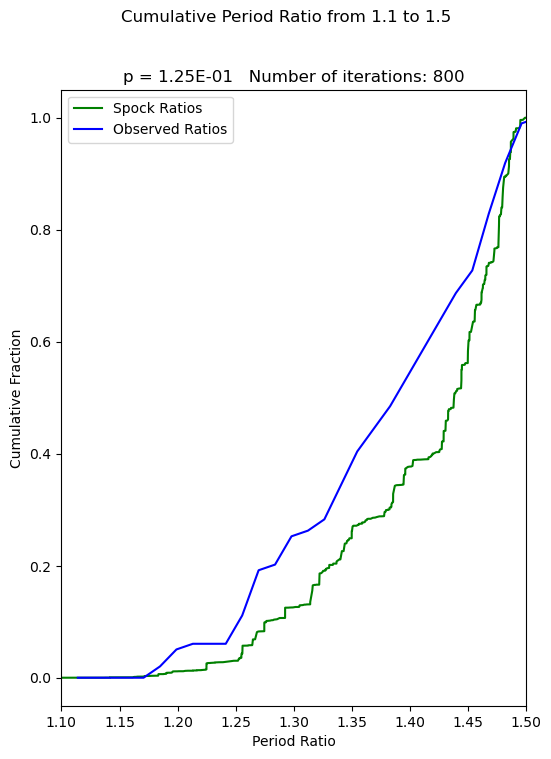

<Figure size 1000x100 with 0 Axes>

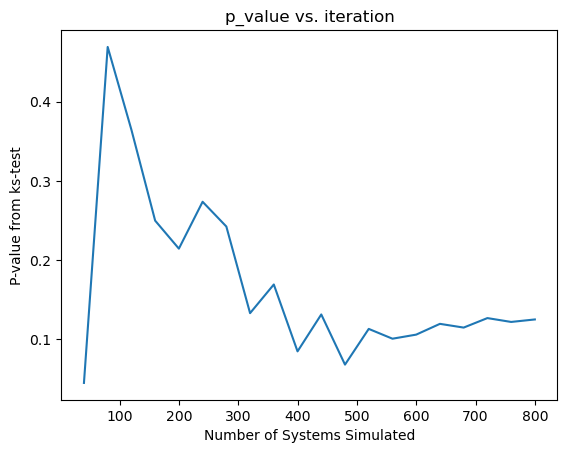

In [8]:
#Below we generate the plots for our population

fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(6)




plt.plot(p_vals, period_ratios, c = 'green')
plt.plot(edges[1:], observed_period_cdf, c = 'blue')
plt.legend(["Spock Ratios", "Observed Ratios"])
plt.suptitle("Cumulative Period Ratio from 1.1 to 1.5")
plt.title("p = " + '%.2E' % Decimal( str(prob_list[-1])  ) + "   Number of iterations: " + str(len(spock_p_list)))
plt.xlabel("Period Ratio")
plt.ylabel("Cumulative Fraction")
plt.xlim(1.1,1.5)
plt.figure(figsize=(10, 1))
plt.show()


plt.plot(iter_list,prob_list)
plt.title("p_value vs. iteration")
plt.xlabel("Number of Systems Simulated")
plt.ylabel("P-value from ks-test")
plt.show()









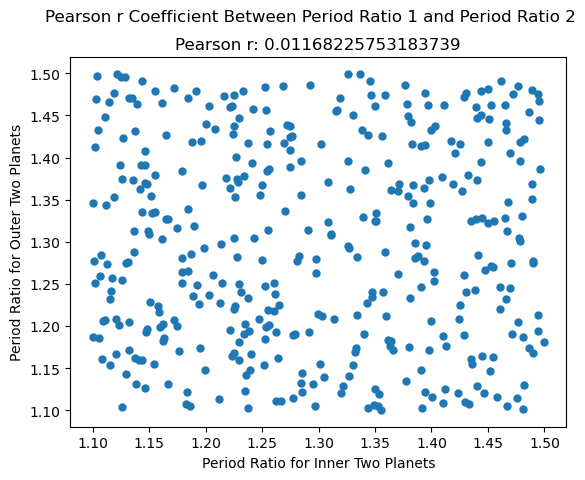

400
400
400
[0.         0.01233749 0.         0.         0.06537106 0.
 0.         0.         0.49183634 0.01372998 0.         0.
 0.         0.         0.68834835 0.         0.00757821 0.04929248
 0.         0.00497487 0.01277454 0.         0.         0.
 0.         0.         0.02333211 0.09766128 0.00976265 0.47112733
 0.12949814 0.         0.00439683 0.         0.01766415 0.
 0.         0.         0.         0.         0.78222036 0.
 0.01181622 0.00800891 0.         0.         0.00410254 0.
 0.13364771 0.         0.         0.         0.00564822 0.93024272
 0.         0.00574699 0.12944303 0.         0.00409127 0.
 0.00403266 0.         0.0082371  0.         0.         0.00522841
 0.         0.         0.00498374 0.         0.         0.00699112
 0.         0.         0.         0.         0.         0.
 0.00409127 0.00454789 0.         0.00779318 0.49915397 0.00508152
 0.         0.         0.         0.00463814 0.         0.00622425
 0.00470493 0.         0.01030867 0.         0.

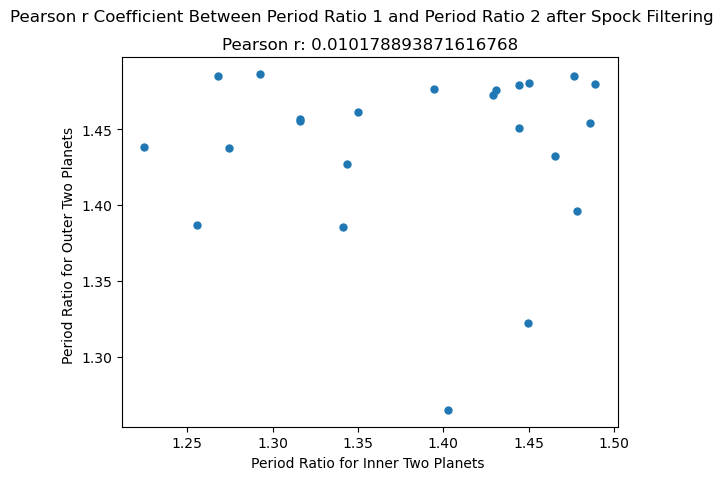

In [9]:
#Here I calculate the Pearson r of the resulting population

my_rho = np.corrcoef(pop3_p1list, pop3_p2list)
pearson_r = my_rho[0][1]
#plt.style.use('seaborn-whitegrid')
plt.plot(pop3_p1list, pop3_p2list, 'o', markersize = 5)
plt.xlabel("Period Ratio for Inner Two Planets")
plt.ylabel("Period Ratio for Outer Two Planets")
plt.title("Pearson r: " + str(pearson_r))
plt.suptitle('Pearson r Coefficient Between Period Ratio 1 and Period Ratio 2')
plt.show()



pearson_pop3_p1_list = []
pearson_pop3_p2_list = []

print(len(pearson_p_weight_array))
print(len(pop3_p1list))
print(len(pop3_p2list))
pearson_cutoff_prob = 0.4

print(pearson_p_weight_array)

for index in range(len(pearson_p_weight_array)):
    if pearson_p_weight_array[index] > pearson_cutoff_prob:
        pearson_pop3_p1_list.append(pop3_p1list[index])
        pearson_pop3_p2_list.append(pop3_p2list[index])


my_rho = np.corrcoef(pearson_pop3_p1_list, pearson_pop3_p2_list)

pearson_r = my_rho[0][1]

#plt.style.use('seaborn-whitegrid')

plt.plot(pearson_pop3_p1_list, pearson_pop3_p2_list, 'o', markersize = 5)


plt.xlabel("Period Ratio for Inner Two Planets ")
plt.ylabel("Period Ratio for Outer Two Planets ")
plt.title("Pearson r: " + str(pearson_r))
plt.suptitle('Pearson r Coefficient Between Period Ratio 1 and Period Ratio 2 after Spock Filtering')
plt.show()


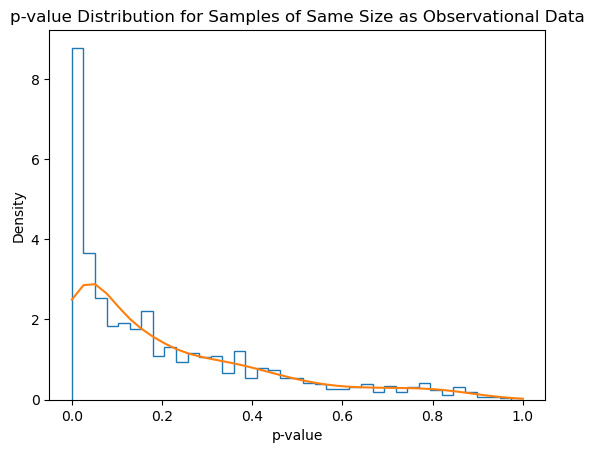

In [12]:
#Here we get a distribution of p-values by choosing many different outcomes. 
#Assume the length of period ratio list is 10,000
#We are going to make Sampled Populations of size 100, calculate p-values, and then make a distribution. 

sample_p_value_list = []



estimator = sns.distributions.ECDF('proportion', complementary=False)
for i in range(1000):
    sample_pratio_list = []
    sample_pratio_weights_list = []
    for j in range(100):
        rand_indx = int(np.random.uniform(0,len(spock_p_list)))
        sample_pratio_list.append(spock_p_list[rand_indx])
        sample_pratio_weights_list.append(p_weight_array[rand_indx])
    #Now that we have a sample_pratio_list, calculate a p_value and append it to the sample_p_value_list
    stat, sample_p_vals = estimator(sample_pratio_list, weights=sample_pratio_weights_list)
    sample_period_ratios = stat
    #Here we calculate the p value and add it to our sample_p_value_list
    ksprob = scipy.stats.kstest(sample_period_ratios, observed_period_cdf, args = (), alternative = 'two-sided',
                                method = 'exact')    
    pvalue = ksprob[1]
    sample_p_value_list.append(pvalue)


density = stats.gaussian_kde(sample_p_value_list)
n, x, _ = plt.hist(sample_p_value_list, bins=np.linspace(0, 1, 40),
                   histtype=u'step', density=True)  
plt.plot(x, density(x))

plt.title("p-value Distribution for Samples of Same Size as Observational Data")
plt.xlabel("p-value")
plt.ylabel("Density")
plt.show()

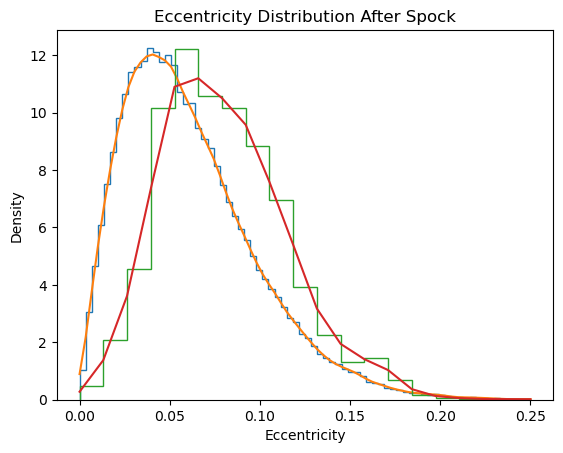

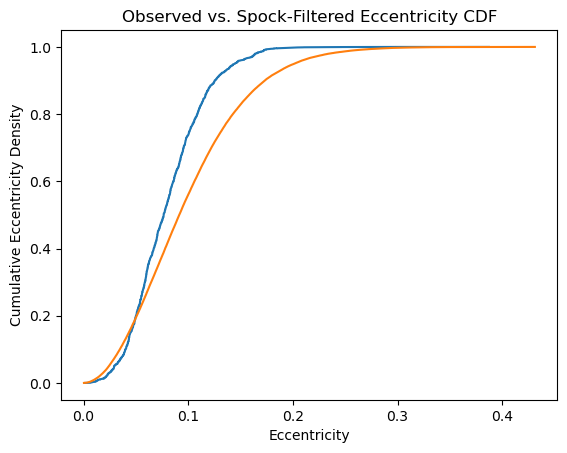

In [8]:


num_iter =100000
obs_e_mean = 0.049      #0.02632     #settings["planetary_system"]["mean_e"]
obs_e_error=  0.013     #settings["planetary_system"]["e_error"]

obs_e_list = []
    
while len(obs_e_list) < num_iter:
    #Generate e from Rayleigh Distribution
    scale = np.random.normal(obs_e_mean, obs_e_error)
    if scale < 0:
        scale = 0
    e = np.random.rayleigh(scale = scale)
    if not (e < 0 or e > 1):
        obs_e_list.append(e)


density = stats.gaussian_kde(obs_e_list)
n, x, _ = plt.hist(obs_e_list, bins=np.linspace(0, 0.25, 75),
                   histtype=u'step', density=True)  
plt.plot(x, density(x))

plt.title("Eccentricity Distribution Before Spock")
plt.xlabel("Eccentricity")
plt.ylabel("Density")




density = stats.gaussian_kde(spock_e_list, weights = triple_weight_array)
n, x, _ = plt.hist(spock_e_list, bins=np.linspace(0, 0.25, 20), weights = triple_weight_array,
                   histtype=u'step', density=True)  
plt.plot(x, density(x))

plt.title("Eccentricity Distribution After Spock")
plt.xlabel("Eccentricity")
plt.ylabel("Density")
plt.show()



#Above plots the pdf's of the e_lists. 
#Below gets the cdf's and p-value





#Calculate that p-value
stat, sample_e_vals = estimator(spock_e_list, weights=triple_weight_array)
sample_e_ratios = stat

plt.plot(sample_e_vals, stat)

stat, obs_sample_e_vals = estimator(e_list)
obs_e_ratios = stat


plt.xlabel("Eccentricity")
plt.ylabel("Cumulative Eccentricity Density")
plt.title("Observed vs. Spock-Filtered Eccentricity CDF")
plt.plot(obs_sample_e_vals, stat)
plt.show()

#Here we calculate the p value and add it to our sample_p_value_list
#ksprob = scipy.stats.kstest(sample_e_ratios, obs_e_ratios, args = (), alternative = 'two-sided',
#                            method = 'exact')    
#pvalue = ksprob[1]

#print("P-value: " + str(pvalue))

